In [4]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/385.2 MB 3.4 MB/s eta 0:01:53
   ---------------------------------------- 0.5/385.2 MB 6.7 MB/s eta 0:00:58
   ---------------------------------------- 1.4/385.2 MB 12.5 MB/s eta 0:00:31
   ---------------------------------------- 2.3/385.2 MB 16.0 MB/s eta 0:00:24
   ---------------------------------------- 3.0/385.2 MB 15.9 MB/s eta 0:00:25
   ---------------------------------------- 3.7/385.2 MB 16.0 MB/s eta 0:00:24
   ---------------------------------------- 4.5/385.2 MB 17.0 MB/s eta 0:00:23
    --------------------------------------- 5.3/385.2 MB 16.9 MB/s eta 0:00:23
    --------------------------------------- 5.9/385.2 MB 16.3 MB/s eta 0:00:24
    --------------------------------------- 6.3/385.2 MB 16.2 MB/s eta 0:00:24
    --------------------------------------- 6.6/385.2 MB 15.1 MB/s e


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
#import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#loading dat
file_1="../Dataset/B0005_dis_dataset.csv"
file_2="../Dataset/B0006_dis_dataset.csv"
dataset_1=pd.read_csv(file_1)
dataset_2=pd.read_csv(file_2)

C_max=2.05

#renaming columns for simplicity
dataset_1.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_1["current_load"]= abs(dataset_1["current_load"])

#removing ideling / starting and ending current level data  
df_1=dataset_1[(dataset_1.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_1["time"]=df_1["time"]/3600

#calculate Soc for each cycle
cycle_count=df_1["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_1[df_1['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_1["Soc"] = [(q / C_max) for q in Soc_list]
df_1["Soh"]=df_1["capacity"]/C_max

# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

#seperating dataset
X_train = df_1[att]
y_train = df_1[["Soh"]]



#renaming columns for simplicity
dataset_2.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_2["current_load"]= abs(dataset_2["current_load"])

#removing ideling / starting and ending current level data  
df_2=dataset_2[(dataset_2.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_2["time"]=df_2["time"]/3600

#calculate Soc for each cycle
cycle_count=df_2["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_2[df_2['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_2["Soc"] = [(q / C_max) for q in Soc_list]
df_2["Soh"]=df_2["capacity"]/C_max

X_test = df_2[att]
y_test = df_2[["Soh"]]

In [6]:
# Random Forest Regressor

regressor1 = RandomForestRegressor(n_estimators=100,random_state=0)
regressor1.fit(X_train,y_train.values.ravel())
rfr_pred= regressor1.predict(X_test)

# Polynomial Regression

regressor = LinearRegression()
regressor.fit(X_train,y_train)

polyregression = PolynomialFeatures(degree=1)
X_poly = polyregression.fit_transform(X_train)
polyregression.fit(X_poly, y_train)
linear = LinearRegression()
linear.fit(X_poly, y_train)
poly_pred= linear.predict(polyregression.fit_transform(X_test))

# LSTM

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(25, activation='tanh', recurrent_activation='sigmoid', return_sequences=True,input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25, return_sequences=True))
lstm_model.add(LSTM(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train, epochs=200,batch_size=32, verbose=1,validation_split=0.2, callbacks=[early_stopping])

# LSTM Predictions
X_test_scaled = scaler.transform(X_test)
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
lstm_pred = lstm_model.predict(X_test_lstm)

# Calculate performance weighted average RFR+lstm
rmse_rfr = np.sqrt(metrics.mean_squared_error(y_test, rfr_pred))
rmse_lstm = np.sqrt(metrics.mean_squared_error(y_test, lstm_pred))

# Assign weights inversely proportional to MSE
weight_rfr = 1 / rmse_rfr
weight_lstm = 1 / rmse_lstm
total_weight = weight_rfr + weight_lstm
weight_rfr /= total_weight
weight_lstm /= total_weight

rfr_pred = rfr_pred.reshape(len(rfr_pred),1)
rfr_lstm = (weight_rfr * rfr_pred + weight_lstm * lstm_pred)

# Calculate performance weighted average poly+lstm

rmse_poly = np.sqrt(metrics.mean_squared_error(y_test, poly_pred))
rmse_lstm = np.sqrt(metrics.mean_squared_error(y_test, lstm_pred))

# Assign weights inversely proportional to MSE

weight_poly = 1 / rmse_poly
weight_lstm = 1 / rmse_lstm
total_weight = weight_poly + weight_lstm
weight_poly /= total_weight
weight_lstm /= total_weight

# Combine predictions
poly_lstm = (weight_poly * poly_pred + weight_lstm * lstm_pred)

Epoch 1/200


d:\Work\Python_version\Python_3.12.4\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1129/1129 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0966 - val_loss: 1.7650e-04
Epoch 2/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3752e-04 - val_loss: 2.0076e-04
Epoch 3/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.0139e-05 - val_loss: 8.0135e-04
Epoch 4/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.8507e-05 - val_loss: 4.0825e-04
Epoch 5/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.2812e-05 - val_loss: 3.1377e-04
Epoch 6/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.8828e-05 - val_loss: 3.1461e-04
Epoch 7/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 9.7749e-06 - val_loss: 1.2754e-04
Epoch 8/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.4982e-06 - val_loss: 3.6388e-05
Epoch 9/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.1553e-06 - val_loss: 1.6124e-05
Epoch 10/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0836e-06 - val_loss: 3.8342e-05
Epoch 11/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3

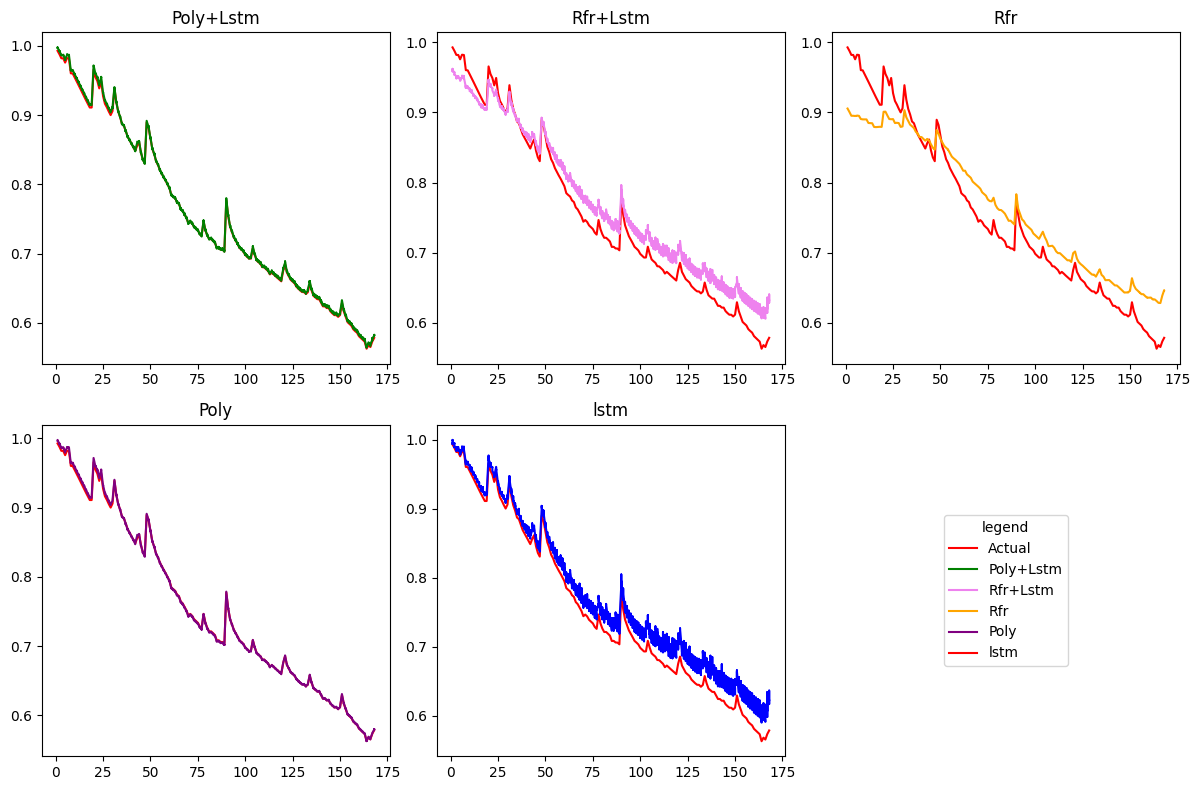

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis object
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
"""
ax.plot(np.array(X_test[["cycle"]]), 3*np.ones_like(X_test["cycle"]),)
ax.plot(np.array(X_test[["cycle"]]), 4*np.ones_like(X_test["cycle"]))
ax.plot(np.array(X_test[["cycle"]]), 5*np.ones_like(X_test["cycle"]), np.array(lstm_pred), color='red', label="lstm")
"""
# Plot data on each subplot
x = np.linspace(0, 10, 100)

axs[0, 0].plot(np.array(X_test[["cycle"]]),np.array(y_test),color='RED', label='Actual')
axs[0, 0].plot(np.array(X_test[["cycle"]]),np.array(poly_lstm),color='green', label="Poly+Lstm")
axs[0, 0].set_title("Poly+Lstm")

axs[0, 1].plot(np.array(X_test[["cycle"]]),np.array(y_test),color='RED', label='Actual')
axs[0, 1].plot(np.array(X_test[["cycle"]]),np.array(rfr_lstm),color='violet', label="Rfr+Lstm")
axs[0, 1].set_title("Rfr+Lstm")

axs[0, 2].plot(np.array(X_test[["cycle"]]),np.array(y_test),color='RED', label='Actual')
axs[0, 2].plot(np.array(X_test[["cycle"]]),np.array(rfr_pred), color='orange', label="Rfr")
axs[0, 2].set_title("Rfr")

axs[1, 0].plot(np.array(X_test[["cycle"]]),np.array(y_test),color='RED', label='Actual')
axs[1, 0].plot(np.array(X_test[["cycle"]]),np.array(poly_pred), color='purple', label="Poly")
axs[1, 0].set_title("Poly")

axs[1, 1].plot(np.array(X_test[["cycle"]]),np.array(y_test),color='RED', label='Actual')
axs[1, 1].plot(np.array(X_test[["cycle"]]),np.array(lstm_pred), color='Blue', label="lstm")
axs[1, 1].set_title("lstm")

# Create a dummy plot in the 6th spot
axs[1, 2].axis('off')  # turn off axis
axs[1, 2].plot([0],[0],color='RED', label='Actual')
axs[1, 2].plot([0],[0],color='green', label="Poly+Lstm")
axs[1, 2].plot([0],[0],color='violet', label="Rfr+Lstm")
axs[1, 2].plot([0],[0], color='orange', label="Rfr")
axs[1, 2].plot([0],[0], color='purple', label="Poly")
axs[1, 2].plot([0],[0], color='red', label="lstm")
axs[1, 2].legend(loc='center', ncol=1, fontsize=10, title='legend')
# Remove the last subplot (since we only have 5 plots)
#fig.delaxes(axs[1, 2])

# Show the plot
plt.tight_layout()
plt.show()